In [1]:
%load_ext autoreload
%autoreload 2

import os
import pickle
import sys
from pathlib import Path
import datetime
import lab.torch as B
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import torch
from wbml import plot
import tueplots
from collections import defaultdict
torch.set_printoptions(profile='full') # 'short'

colors = sns.color_palette("bright")
sns.set_style("whitegrid")
sns.set_palette(colors)


from tueplots import bundles, fontsizes, figsizes
plt.rcParams.update({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()})
matplotlib.rcParams["figure.dpi"] = 300  # for high quality, retina plots


from wbml import plot

### Locations

In [2]:
img_folder = 'tmp'

In [43]:
include = [
            # Adult GVI
            "draft_results/Adult/GVI/A/07-24-13.50.19_sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi",
            "draft_results/Adult/GVI/A/07-24-14.46.53_seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi",

            # Bank GVI
            "draft_results/Bank/GVI/A/07-24-13.54.22_seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi",
            "draft_results/Bank/GVI/A/07-24-14.48.55_seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m",

            # Bank Seq
            "draft_results/Bank/Seq/A/07-24-13.01.24_seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",
            "draft_results/Bank/Seq/A/07-24-13.21.51_seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s",
            
            # Adult Seq
            "draft_results/Adult/Seq/A/07-24-10.11.10_seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight",
            "draft_results/Adult/Seq/A/07-24-10.12.05_seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi",
            # "draft_results/Adult/Seq/B/07-25-16.02.09_seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m",
            # "draft_results/Adult/Seq/B/07-25-17.56.14_seq-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s",
            

            # Bank - Split B
            # "draft_results/Bank/Seq/B/07-25-17.58.15_seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s-100m", 
            # "draft_results/Bank/Seq/B/07-25-19.29.52_seq-mfvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-02lr-2s",

                # lower lr
            # "draft_results/Adult/Seq/B/07-28-16.00.03_seq-pvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-005lr-2s-100m",
            # "draft_results/Adult/Seq/B/07-28-16.01.36_seq-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-005lr-2s",
            # "draft_results/Adult/Seq/B/07-28-16.38.00_seq-mfvi-adult-10c-10g-1000l-nealprior-splitb-128b-0-01lr-2s",

                # HPC!
            "draft_results/Bank/Seq/B/07-29-11.03.32_seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-0005lr-2s-100m-verify",
            # "draft_results/Bank/Seq/B/07-29-16.57.02_seq-pvi-bank-10c-10g-2000l-nealprior-splitb-128b-0-001lr-2s-100m",
            "draft_results/Bank/Seq/B/07-29-11.46.44_seq-mfvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-0005lr-2s",
            
            # Bank Sync
            "draft_results/Bank/Sync/B/07-29-17.11.15_sync-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-001lr-2s-10m",
            "draft_results/Bank/Sync/A/07-26-13.29.58_sync-pvi-bank-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l",
            "draft_results/Bank/Sync/A/07-24-16.00.58_sync-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s",

            # Adult Sync
            "draft_results/Adult/Sync/A/07-24-12.41.02_sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m",
            "draft_results/Adult/Sync/A/07-24-12.41.48_sync-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s",

]

In [44]:
########### READ LOG FILES ###########

main_dir = os.path.dirname(os.path.abspath(os.getcwd()))
res = "draft_results/"
res_dir = os.path.join(main_dir, res)

infinite_defaultdict = lambda: defaultdict(infinite_defaultdict)
logs = infinite_defaultdict()

# Column headers
pvi_name = "PVI"
variational_name = "Method"
client_name = "Client"
split_name = "Split"
dataset_name = 'Dataset'
experiment_name ='Experiment name'
num_clients_name = 'Number of clients'

for dataset_type in os.listdir(res_dir):
    if dataset_type in ["Adult", "Bank", "Credit"]:
        for pvi_type in os.listdir(os.path.join(res_dir, dataset_type)):
            for split_type in os.listdir(os.path.join(res_dir, dataset_type, pvi_type)):
                
                exp_dir = os.path.join(res_dir, dataset_type, pvi_type, split_type)

                for exp in os.listdir(exp_dir):

                    q_type = exp.split('_')[1].split('-')[1]
                    num_clients = int(exp.split('_')[1].split('-')[3].split('c')[0])

                    # Erroneous file naming
                    if q_type == 'pvi': q_type = 'gi'
                    
                    metrics_dir = os.path.join(exp_dir, exp, "metrics")
                    _exp_name = '-'.join(exp.split('_')[1:])
                    
                    # Exclude experiments in array
                    if os.path.join(res, dataset_type, pvi_type, split_type, exp) in include:
                    
                        # Existing log file
                        if type(logs[dataset_type][pvi_type][split_type][q_type][experiment_name]) == str:
                            # OVERWRITE EXISTING LOG FILE
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type}: {logs[dataset_type][pvi_type][split_type][q_type][experiment_name]} ==> {_exp_name}")
                        else:
                            print(f"{dataset_type}/{pvi_type}/{split_type}/{q_type} = {_exp_name}")

                        logs[dataset_type][pvi_type][split_type][q_type][experiment_name] = _exp_name
                        for log_name in os.listdir(metrics_dir):
                            name = log_name.split('_')[0]
                            
                            logs[dataset_type][pvi_type][split_type][q_type][name] = pd.read_csv(os.path.join(metrics_dir, log_name))

                            # Add column values
                            logs[dataset_type][pvi_type][split_type][q_type][name][pvi_name] = pvi_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][variational_name] = q_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][split_name] = split_type.upper()
                            logs[dataset_type][pvi_type][split_type][q_type][name][dataset_name] = dataset_type
                            if name != 'server':
                                logs[dataset_type][pvi_type][split_type][q_type][name][client_name] = name
                            logs[dataset_type][pvi_type][split_type][q_type][name][num_clients_name] = num_clients
                            logs[dataset_type][pvi_type][split_type][q_type][name][experiment_name] = _exp_name

Bank/Seq/A/gi = seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m
Bank/Seq/A/mfvi = seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s
Bank/Seq/B/mfvi = seq-mfvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-0005lr-2s
Bank/Seq/B/gi = seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-0005lr-2s-100m-verify
Bank/GVI/A/mfvi = seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi
Bank/GVI/A/gi = seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m
Bank/Sync/A/gi = sync-pvi-bank-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l
Bank/Sync/A/mfvi = sync-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s
Bank/Sync/B/gi = sync-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-001lr-2s-10m
Adult/Seq/A/gi = seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight
Adult/Seq/A/mfvi = seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi
Adult/GVI/A/gi = seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi
Adult/GVI/A/mfvi = sync-mfvi-adult-1c-10g-100

Merge dataframes for plotting purposes.

In [45]:
clients = []
for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name != experiment_name and name != 'server': clients.append(log)

client = pd.concat(clients, ignore_index=True)

In [46]:
servers = []

for dataset, d in logs.items():
    for pvi_setting, dd in d.items():
        for split_setting, ddd in dd.items():
            for q_setting, dddd in ddd.items():
                for name, log in dddd.items():
                    if name != experiment_name and name == 'server': servers.append(log)

server = pd.concat(servers, ignore_index=True)

In [47]:
server.groupby(by=[dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Dataset  Split  PVI   Split  Method  Experiment name                                                          
Adult    A      GVI   A      GI      seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi                  11
                             MFVI    sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi                     11
                SEQ   A      GI      seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight      101
                             MFVI    seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi              101
                SYNC  A      GI      sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m                    11
                             MFVI    sync-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s                        11
Bank     A      GVI   A      GI      seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m                       11
                             MFVI    seq-mfvi-bank-1c-10g-1000l

In [48]:
server.groupby(by=[variational_name, dataset_name, split_name, pvi_name, split_name, variational_name, experiment_name]).size()

Method  Dataset  Split  PVI   Split  Method  Experiment name                                                          
GI      Adult    A      GVI   A      GI      seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi                  11
                        SEQ   A      GI      seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight      101
                        SYNC  A      GI      sync-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m                    11
        Bank     A      GVI   A      GI      seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m                       11
                        SEQ   A      GI      seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m                     101
                        SYNC  A      GI      sync-pvi-bank-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l     11
                 B      SEQ   B      GI      seq-pvi-bank-10c-10g-1000l-nealprior-splitb-128b-0-0005lr-2s-100m-verify     101

# Plotting

test mll

In [52]:
dataset = "Bank"
split = "A"
omit_sync_mfvi = True
save_plot = True

data = server.loc[server[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'communications'])

append_file_name = ""

# Check whether these are the experiments you want to plot.
data.groupby(by=[variational_name, split_name, dataset_name, experiment_name]).size()

Method  Split  Dataset  Experiment name                                                          
GI      A      Bank     seq-pvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m                     101
                        seq-pvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m                       11
                        sync-pvi-bank-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l     11
MFVI    A      Bank     seq-mfvi-bank-10c-10g-1000l-nealprior-128b-0-02lr-2s                         101
                        seq-mfvi-bank-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi                       11
dtype: int64

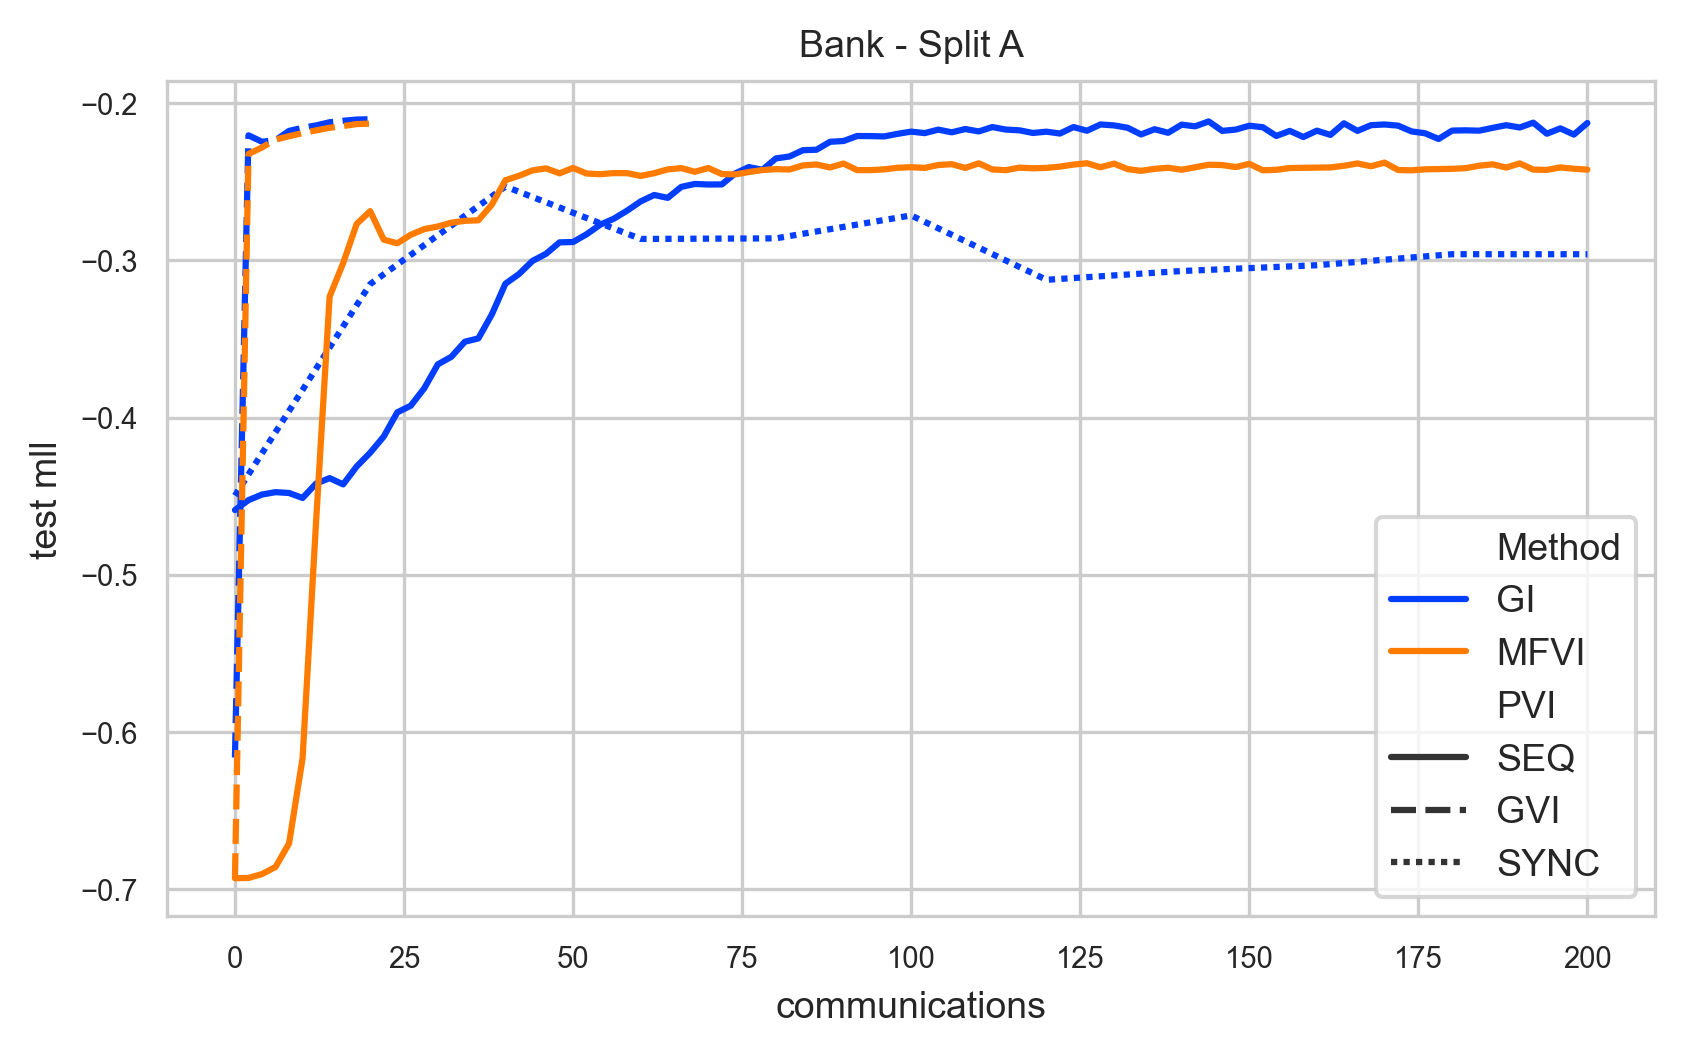

In [53]:
_start = datetime.datetime.utcnow()
_time = _start.strftime("%m-%d-%H-%M")

with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)

    x_metric = 'communications'
    y_metric = 'test_mll'
    
    sns.lineplot(data=data, x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    file_name = f"./{img_folder}/{dataset}_{split}_{_time}_server_{x_metric}_{y_metric}"
    # if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    file_name += append_file_name
    if save_plot: plt.savefig(file_name)
    plt.show()

### Client

In [54]:
client.columns

Index(['global_iteration', 'local_iteration', 'total_iteration', 'vfe', 'll',
       'kl', 'error', 'PVI', 'Method', 'Split', 'Dataset', 'Client',
       'Number of clients', 'Experiment name'],
      dtype='object')

In [315]:
dataset = "Adult"
split = "A"
omit_sync_mfvi = True
save_plot = False

data = client.loc[client[split_name] == split]
data = data.loc[data[dataset_name] == dataset]

if omit_sync_mfvi:
    data = data.loc[~((data[pvi_name] == 'SYNC') & (data[variational_name] == 'MFVI'))]

data = data.sort_values(by=[variational_name, split_name, dataset_name, experiment_name, 'total_iteration'])

# Check whether these are the experiments you want to plot.
pd.unique(data[experiment_name])

array(['seq-pvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-100m-project-tight',
       'seq-pvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-100m-gvi',
       'sync-pvi-adult-10c-10g-2000l-nealprior-splita-128b-0-02lr-2s-100m-longer-l',
       'seq-mfvi-adult-10c-10g-1000l-nealprior-128b-0-02lr-2s-equaltogi',
       'sync-mfvi-adult-1c-10g-1000l-nealprior-128b-0-02lr-2s-gvi'],
      dtype=object)

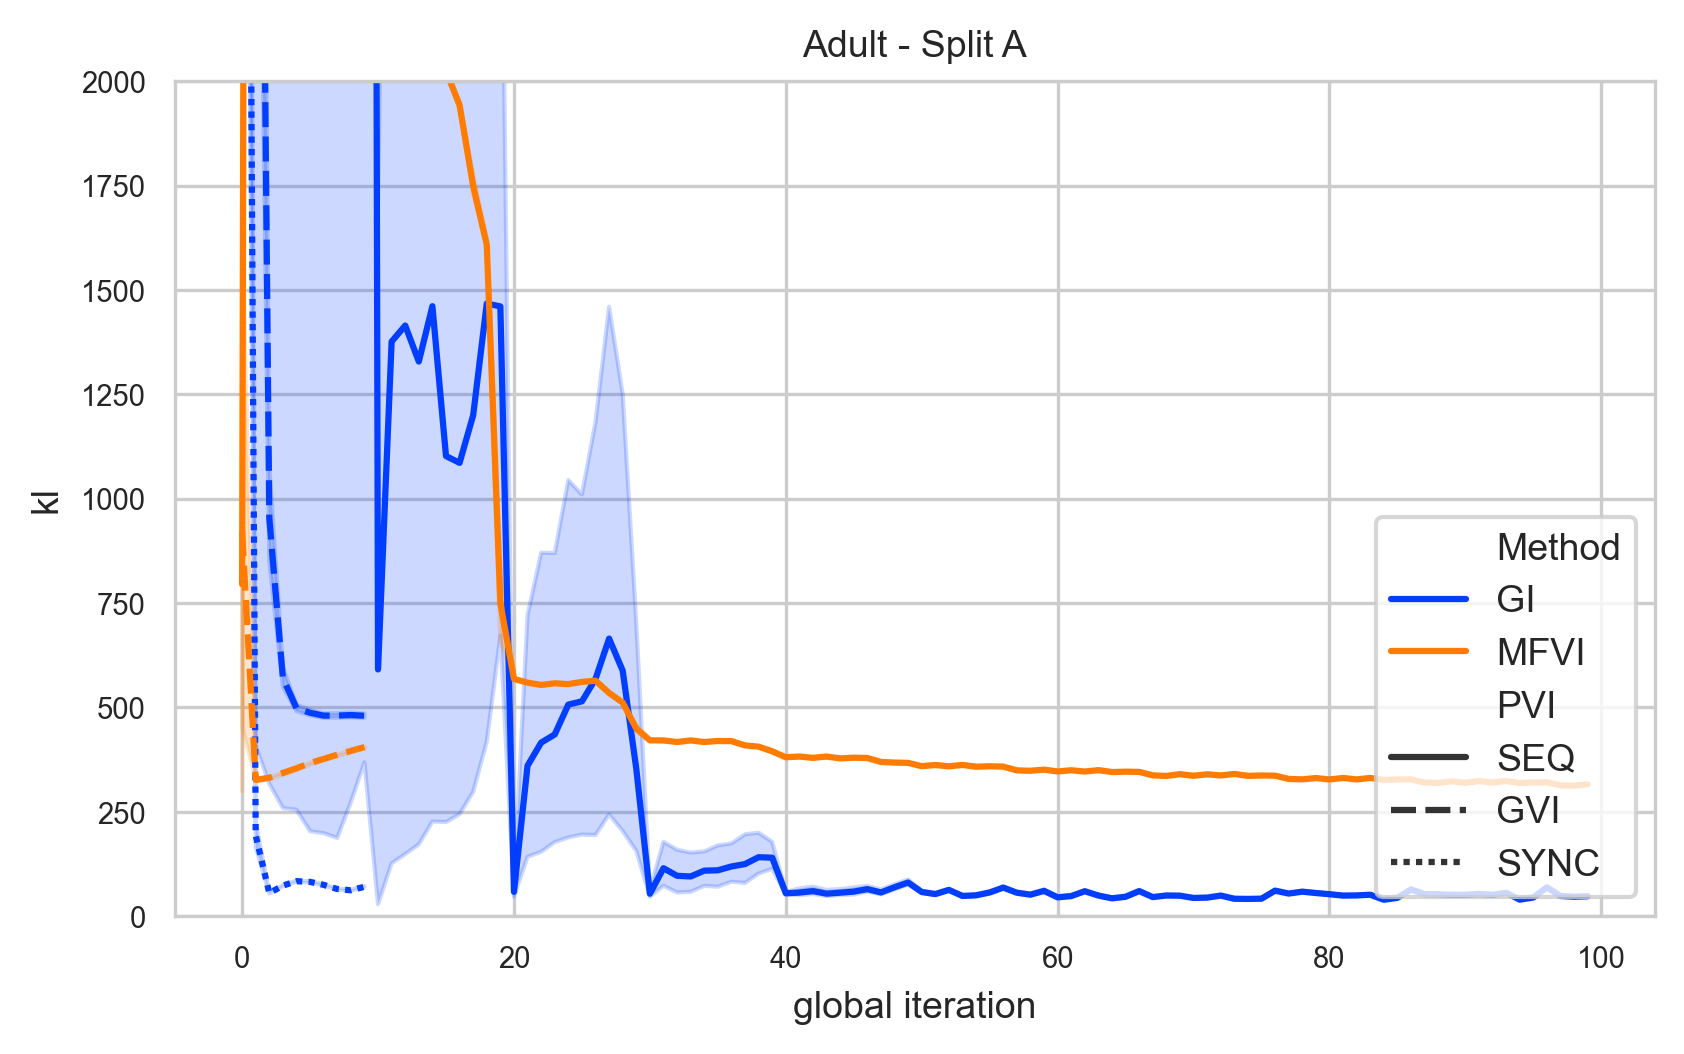

In [321]:
with plt.rc_context({**figsizes.neurips2022(ncols=1), **fontsizes.neurips2022()}):
    fig, ax = plt.subplots(1, 1)
    
    y_metric = "kl"
    x_metric = "global_iteration"
    
    sns.lineplot(data=data.loc[data[dataset_name] == dataset], x=x_metric, y=y_metric, ax=ax, hue=variational_name, style=pvi_name)
    
    ax.set_title(f'{dataset} - Split {split}')    
    ax.set_ylabel(' '.join(y_metric.split('_')))
    ax.set_xlabel(' '.join(x_metric.split('_')))
    ax.legend(loc="lower right", prop={"size": 9})

    ax.set_ylim(0, 2000)

    file_name = f"./{img_folder}/{split}_{dataset}_client_{x_metric}_{y_metric}"
    if omit_sync_mfvi: file_name += "_omit_sync_mfvi"

    if save_plot: plt.savefig(file_name)
    plt.show()
